In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
# automap documentation - https://docs.sqlalchemy.org/en/13/orm/extensions/automap.html
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
tables = Base.classes.keys()
tables

['measurement', 'station']

In [8]:
# Get column names and data types for each table
inspector = inspect(engine)
for table in tables:
    columns = inspector.get_columns(table)
    for c in columns:
        print(c['name'],c['type'], end='   ')
    print()
    print('---------------------------------------')

id INTEGER   station TEXT   date TEXT   prcp FLOAT   tobs FLOAT   
---------------------------------------
id INTEGER   station TEXT   name TEXT   latitude FLOAT   longitude FLOAT   elevation FLOAT   
---------------------------------------


In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
# Method to get table columns without inspect
print(Measurement.__table__.columns.keys())
print(Station.__table__.columns.keys())

['id', 'station', 'date', 'prcp', 'tobs']
['id', 'station', 'name', 'latitude', 'longitude', 'elevation']


# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
## Get most recent day and convert to datetime object
most_recent_day = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
dt_obj = dt.datetime.strptime(most_recent_day[0], '%Y-%m-%d')
## Subract a year to find datetime object of date from a year earlier of most_recent_day
year_ago = dt.date(dt_obj.year-1,dt_obj.month,dt_obj.day)

# Perform a query to retrieve the date and precipitation scores
last_year_prcp = session.query(Measurement.date,Measurement.prcp).\
                        filter(Measurement.date >= year_ago).all()
# Save the query results as a Pandas DataFrame 
prcp_df = pd.DataFrame(last_year_prcp).dropna()
# Change date data type from string to datetime64[ns] (SO reference below for why)
prcp_df['date'] = pd.to_datetime(prcp_df['date'])
# Set the index to the date column and sort by index
prcp_df = prcp_df.set_index('date').sort_index()

# for reference - https://stackoverflow.com/questions/55584972/showing-only-every-n-dates-on-x-axis-or-grouping-by-month-to-reduce-x-axis-c

Text(0.5, 1.0, 'Precipitation')

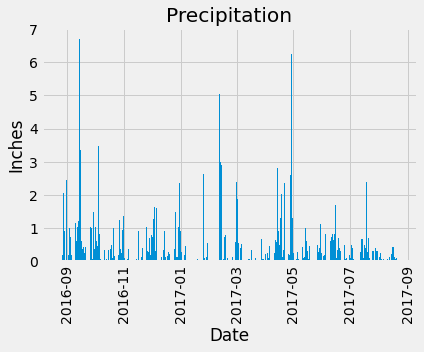

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure()
plt.bar(prcp_df.index,prcp_df['prcp'])
plt.xticks(rotation=90)
plt.ylabel('Inches')
plt.xlabel('Date')
plt.title('Precipitation')

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [23]:
# Design a query to show how many stations are available in this dataset?
ustations = session.query(Measurement.station)
print(f"There are a total of {ustations.count()} stations")
print(f"There are {ustations.distinct().count()} unique stations")

There are a total of 19550 stations
There are 9 unique stations


In [34]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_freq = session.query(Measurement.station,func.count(Measurement.station)).\
                group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
station_freq

## References
# count and groupby -- https://stackoverflow.com/questions/1052148/group-by-count-function-in-sqlalchemy
# descending order -- https://stackoverflow.com/questions/4186062/sqlalchemy-order-by-descending

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [65]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station = str(station_freq[0][0]) # grab the station id from previous query
mas_temp = session.query(Measurement.tobs).\
                        filter(Measurement.station == most_active_station).\
                        order_by(Measurement.tobs).all()
# convert tuple like element to float type
mas_temp = [float(x[0]) for x in mas_temp]
mas_max_temp = max(mas_temp) # or = mas_temp[-1] because of order_by in query
mas_min_temp = min(mas_temp) # or = mas_temp[0] because of order_by in query
mas_avg_temp = np.mean(mas_temp)
print(f"The minimum temp measured by station {most_active_station} is {mas_min_temp} in Fahrenheit")
print(f"The maximum temp measured by station {most_active_station} is {mas_max_temp} in Fahrenheit")
print(f"The average temp measured by station {most_active_station} is {mas_avg_temp:.1f} in Fahrenheit")

The minimum temp measured by station USC00519281 is 54.0 in Fahrenheit
The maximum temp measured by station USC00519281 is 85.0 in Fahrenheit
The average temp measured by station USC00519281 is 71.7 in Fahrenheit


Text(0.5, 0, 'Temperature (F)')

<Figure size 432x288 with 0 Axes>

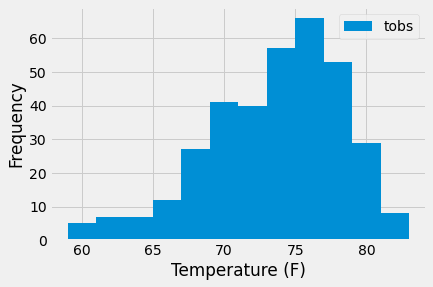

In [76]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_year_temp = session.query(Measurement.tobs).\
                        filter(Measurement.station == most_active_station).\
                        filter(Measurement.date >= year_ago).all() # year_ago from the begining of notebook
last_year_temp_df = pd.DataFrame(last_year_temp)
plt.figure()
last_year_temp_df.plot(kind='hist',bins=12)
plt.xlabel('Temperature (F)')

## Bonus Challenge Assignment

In [82]:
# Temperature Analysis I
# perform query to find all temps from all stations in June and December for all years
june_temp = session.query(Measurement.tobs).\
            filter(func.strftime("%m", Measurement.date) == "06").all()
dec_temp = session.query(Measurement.tobs).\
            filter(func.strftime("%m", Measurement.date) == "12").all()
# convert tuple like element to float type
june_temp = [float(x[0]) for x in june_temp]
dec_temp = [float(x[0]) for x in dec_temp]


[76.0,
 74.0,
 74.0,
 64.0,
 64.0,
 67.0,
 77.0,
 66.0,
 69.0,
 68.0,
 68.0,
 71.0,
 74.0,
 67.0,
 66.0,
 69.0,
 71.0,
 70.0,
 70.0,
 74.0,
 74.0,
 71.0,
 75.0,
 75.0,
 72.0,
 69.0,
 68.0,
 73.0,
 74.0,
 73.0,
 73.0,
 73.0,
 73.0,
 71.0,
 73.0,
 73.0,
 77.0,
 72.0,
 71.0,
 73.0,
 70.0,
 73.0,
 69.0,
 74.0,
 72.0,
 71.0,
 72.0,
 72.0,
 70.0,
 73.0,
 73.0,
 72.0,
 73.0,
 73.0,
 72.0,
 63.0,
 65.0,
 71.0,
 76.0,
 70.0,
 76.0,
 69.0,
 69.0,
 69.0,
 74.0,
 76.0,
 74.0,
 73.0,
 73.0,
 74.0,
 73.0,
 73.0,
 73.0,
 74.0,
 74.0,
 71.0,
 73.0,
 72.0,
 64.0,
 66.0,
 73.0,
 72.0,
 65.0,
 64.0,
 69.0,
 68.0,
 77.0,
 71.0,
 71.0,
 69.0,
 68.0,
 68.0,
 69.0,
 70.0,
 72.0,
 76.0,
 75.0,
 69.0,
 71.0,
 71.0,
 71.0,
 68.0,
 65.0,
 70.0,
 69.0,
 69.0,
 71.0,
 67.0,
 73.0,
 74.0,
 73.0,
 67.0,
 74.0,
 75.0,
 75.0,
 74.0,
 67.0,
 73.0,
 73.0,
 71.0,
 72.0,
 71.0,
 68.0,
 65.0,
 69.0,
 70.0,
 70.0,
 74.0,
 71.0,
 74.0,
 73.0,
 72.0,
 74.0,
 72.0,
 74.0,
 75.0,
 74.0,
 70.0,
 74.0,
 70.0,
 66.0,
 61.0,
 63.0,

In [77]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
